## Analysing CIA Factbook Data with SQLite and Python

In this project, we'll be using SQL (and a little pandas) to analyse data from the CIA World FActbook.

To get started, we'll need to import the sqlite3 Python module which contains methods for working with databases. We then need to create a Connection object, which represents the database we're working with (in this case factbook.db).

Then, we'll create a Cursor object. The Cursor class has various methods for working with database, but right now the most import ones for our purposes are execute and fetchall. Execute simply executes a query in the form of a string. Fetchall will return all of the rows of our query result. We can use these two methods to find out some useful information about our database.

Normally, you need to know a table's name in order to be able to query it. Since we don't know that at the moment, we can use q1 below to get some information on our database, from which we can find the name of the tables it contains.

In [1]:
import sqlite3

conn = sqlite3.connect("factbook.db")
cursor = conn.cursor()

q1 = "SELECT * FROM sqlite_master WHERE type = 'table'"
cursor.execute(q1).fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'facts',
  'facts',
  47,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float)')]

sqlite_master is a special table which contains information regarding the database. It happens to be formatted as a list of tuples, hence why q1 returned the series of tuples we've just seen.

sqlite_master contains the following information:
<br>
<br>
type TEXT
<br>
name TEXT
<br>
tbl_name TEXT
<br>
rootpage INTEGER
<br>
sql TEXT
<br>
<br>
We don't need to worry about what most of this is, but I mention it here because it helps us determine what each of the elements of the tuples above represents. Since we're looking for table name, we can simply look at the second element of each of the tuples to find the table name. When we do this, we see that our database has two tables, one named "sqlite_sequence" and the other named "facts". sqlite_sequence is a special kind of table which we can ignore. For now, we're only interested in the facts table, as now we can use this table name in our queries going forward.

An alternative way of getting the above information is to use the pandas method read_sql_query, which returns a DataFrame object of the results of our query.

In [2]:
import pandas as pd

pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


This is a much easier to understand representation than what we saw before. We'll be using the DataFrame representation over the list of tuples for this reason, but the information contained is essentially the same.

Now that we know the name of the table we want to look at, we can take a look at the first few rows of our table with a fresh query. We'll do this with the limit clause. Limit n returns the first n rows of results.

In [3]:
q2 = "SELECT * FROM facts LIMIT 5"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


### Summary Statistics

Let's now look at the summary statistics of our table. Summary statistics are statistics that summarise all of the data in a particular column, such as: sum, min, max, and avg.

We'll look at the minimum and maximum populations, and the minimum and maximum population growth rates. We could do this with multiple queries, such as q3 below. But a faster way is to combine all of those queries into a single query, as in q4.

In [4]:
q3 = "SELECT MIN(population) FROM facts"
pd.read_sql_query(q3,conn)

,MIN(population)
0,0


In [5]:
q4 = "SELECT MIN(population) min_pop, MAX(population) max_pop, MIN(population_growth) min_growth, MAX(population_growth) max_growth FROM facts"
pd.read_sql_query(q4, conn)

,min_pop,max_pop,min_growth,max_growth
0,0,7256490011,0.0,4.02


Summary statistics such as min and max are useful because they can help us quickly identify outliers in our table. From the above query we can see that there are two unusual results: a minimum population  of 0, and a maximum population value of 7.2 billion.

Let's look at the rows where these results occur to find out more. Let's also start labelling our queries so they're more informative and easier to keep track of.

In [6]:
q_min_pop_check = "SELECT *, MIN(population) FROM facts"
pd.read_sql_query(q_min_pop_check, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,MIN(population)
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,0


In [7]:
q_max_pop_check = "SELECT *, MAX(population) FROM facts"
pd.read_sql_query(q_max_pop_check, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,MAX(population)
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,7256490011


Now the seemingly odd results make sense, and they tell us a little more about the data set. From just the first five rows, it looked as if the table only contained data on countries, but we can see now that it contains data on continents (well, at least Antarctica - we'd need to investigate further to see whether other continents are contained in the table) and also the world. The information these kinds of rows contain would be very useful if we were looking for trends on a larger scale.

### Plotting Histograms

By using SQL in combination with pandas, we can filter the results that our DataFrame contains before we start working with the DataFrame itself. While we could filter the contents of our DataFrame with pandas, one advantage of using SQL initially is that it stores the data contained in the table in the computer's disk rather than the computer's memory (unlike pandas, which needs the data in memory). This means its more capable of handling larger datasets. So, if our dataset was large, we could run an SQL query first and filter it down before making it into a dataframe.

Let's take advantage of the fact that we can return the results of our queries in the form of DataFrames by plotting some histograms of the data.

First, we'll select only the data we want with a query and return it in the form of a DataFrame. While the data in the World and Antarctica columns aren't outliers per se, they'll still mess with our histograms, so it's best to remove them.

Once we have our DataFrame, we'll plot the results as a histogram.

Let's make histograms for four of the columns: population, population_growth, birth_rate, and death_rate.

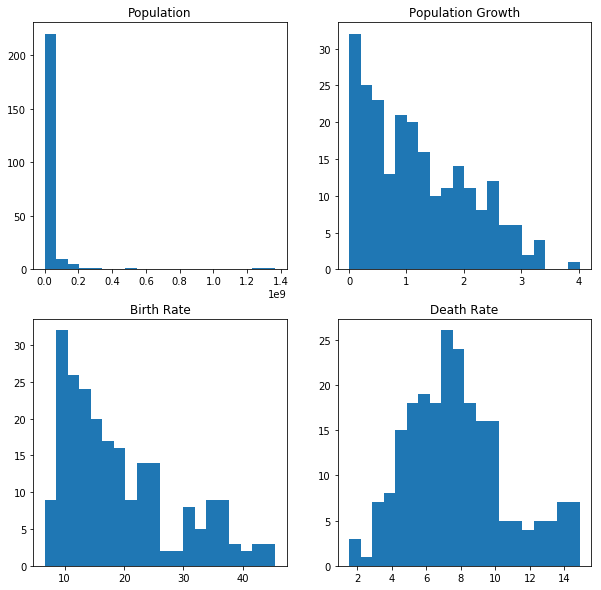

In [11]:
q_filter = "SELECT population, population_growth, birth_rate, death_rate FROM facts WHERE name != 'World' AND name != 'Antarctica'"
filtered = pd.read_sql_query(q_filter, conn)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure(figsize = (10,10))
plots = ["population", "population_growth", "birth_rate", "death_rate"]
titles = ["Population", "Population Growth", "Birth Rate", "Death Rate"]

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    plot = filtered[plots[i]]
    ax.hist(plot[~np.isnan(plot)], bins = 20)
    title = titles[i]
    plt.title(str(title))
    
plt.show()

So, population growth rate is never higher than 4% per year. Birth rate is varied but typically below 20 births per 1,000 people per year. Death rate is typically around 7-8 deaths per 1,000 people per year, but can be as high as ~15 deaths per 1,000 people per year.

Our histogram for population is not very informative, however. The range is still being thrown off by two countries with populations of over 1.2 billion. Let's plot the population histogram again and try and make it more informative by removing those values.

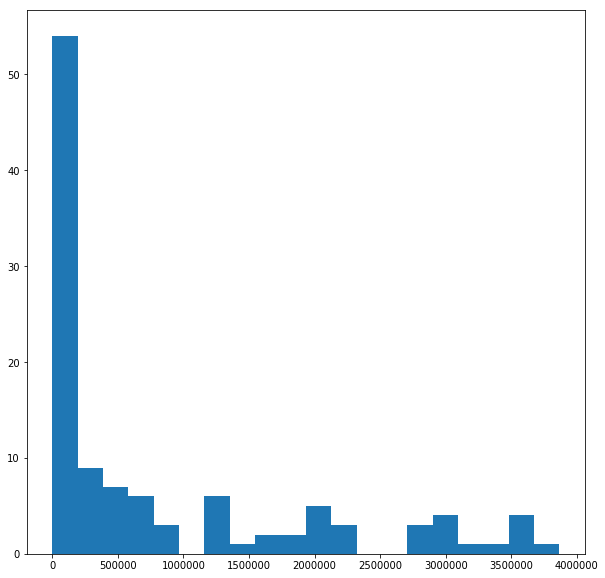

In [19]:
q_filter_pop = "SELECT population FROM facts WHERE name != 'Antarctica' AND population < 4000000"
filtered_pop = pd.read_sql_query(q_filter_pop, conn)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot (1,1,1,)
ax.hist(filtered_pop["population"][~np.isnan(filtered_pop["population"])], bins = 20)
plt.title = "Population"

This is certainly better. While There are still a lot of countries in the first bin, we have a far clearer idea of the distribution of populations. It is interesting that most countries have what we would probably consider tiny populations of less than 200,000 people.

### Analysis with Subqueries

Let's finish off our analysis with some more complicated queries. We'll calculate which countries have the highest population density, and which countries have the highest ratios of water to land.

In [24]:
q_pop_density = "SELECT name, population / area_land population_density FROM facts ORDER BY population_density DESC LIMIT 20"
top_20_pop_density = pd.read_sql_query(q_pop_density, conn)
top_20_pop_density

,name,population_density
0,Macau,21168
1,Monaco,15267
2,Singapore,8259
3,Hong Kong,6655
4,Gaza Strip,5191
5,Gibraltar,4876
6,Bahrain,1771
7,Maldives,1319
8,Malta,1310
9,Bermuda,1299


At a glance, most of these countries seem to be small (geographically speaking). Let's make another list of the 20 highest population densities that have a land area below the average.

In [32]:
q_avg_densities = "SELECT name, population / area_land population_density FROM facts WHERE area_land < (SELECT AVG(area_land) FROM facts) ORDER BY population_density DESC LIMIT 20"
above_avg_densities = pd.read_sql_query(q_avg_densities, conn)
above_avg_densities

,name,population_density
0,Macau,21168
1,Monaco,15267
2,Singapore,8259
3,Hong Kong,6655
4,Gaza Strip,5191
5,Gibraltar,4876
6,Bahrain,1771
7,Maldives,1319
8,Malta,1310
9,Bermuda,1299


Our top 20 coutries are exactly the same! This is probably what we would expect - that the smaller countries in terms of land area are the countries that are more likely to have a high population density. But, the result is nonetheless interesting.